In [35]:
import tensorflow as tf
from tensorflow import keras

import yfinance as yf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import datetime

mpl.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['axes.grid'] = False

import plotly.offline as py
# That's line needed if you use jupyter notebook (.ipynb):
py.init_notebook_mode(connected=True)

import plotly.graph_objects as go

In [5]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [6]:
# Create candlestick chart to visualize Netflix (Symbol: NFLX) values across time from 5 years ago to present
tickerSymbol = 'NFLX'
today = datetime.date.today()
start = datetime.datetime(today.year-5,today.month,today.day)


def candleStick(symbol, startdate, enddate):
    tickerData = yf.Ticker(symbol)
    df = tickerData.history(period='1d', start=startdate, end=enddate)
    
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])

    fig.update_layout(
        title= {
            'text': symbol,
          'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
          font=dict(
            family="Times New Roman",
            size=20,
            color="#7f7f7f"
        )
        )

    fig.show()

In [7]:
candleStick(tickerSymbol, start, today)

# Preparing the data

In [56]:
def dataFrame(symbol, period, startdate, enddate):
    
    columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    tickerData = yf.Ticker(symbol)
    tickerDf = tickerData.history(period=period, start=startdate, end=enddate)
    
    return tickerDf[columns]

df = dataFrame(tickerSymbol, '1d', start, today)

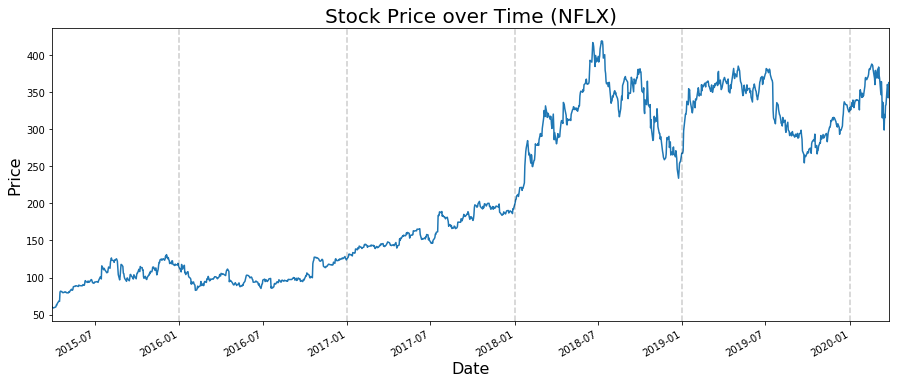

In [58]:
def plotChart(df):
    plt.figure(figsize=(15,6))
    df['Close'].plot()
    plt.title('Stock Price over Time (%s)'%tickerSymbol, fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Price', fontsize=16)
    
    for year in range(2015,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

plotChart(df)

In [60]:
# Split dataset 80:20 train:test
# Print length of subsets
df1 = df[['Close']]

train_size = int(len(df1) * 0.8)
test_size = len(df1) - train_size

# Standarize dataset values to reduce loss
train_mean = train.mean()
train_std = train.std()

df1 = (df1-train_mean)/train_std

train, test = df1.iloc[0:train_size], df1.iloc[train_size:len(df1)]
print(len(train), len(test))

1007 252


In [61]:
# Values of training dataset now standardize
train

,Close
Date,
2015-03-30,-1.258336
2015-03-31,-1.266721
2015-04-01,-1.271812
2015-04-02,-1.270515
2015-04-06,-1.258735
...,...
2019-03-22,1.742780
2019-03-25,1.794888
2019-03-26,1.732398


In [63]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [73]:
# (samples, time_steps, features)
time_steps = 5

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(1002, 5, 1) (1002,)


In [65]:
X_train

array([[[-1.25833595],
        [-1.26672119],
        [-1.27181222],
        [-1.27051451],
        [-1.25873525]],

       [[-1.26672119],
        [-1.27181222],
        [-1.27051451],
        [-1.25873525],
        [-1.25713806]],

       [[-1.27181222],
        [-1.27051451],
        [-1.25873525],
        [-1.25713806],
        [-1.23158305]],

       ...,

       [[ 1.72051933],
        [ 1.88463038],
        [ 1.91108381],
        [ 1.74278013],
        [ 1.79488839]],

       [[ 1.88463038],
        [ 1.91108381],
        [ 1.74278013],
        [ 1.79488839],
        [ 1.73239841]],

       [[ 1.91108381],
        [ 1.74278013],
        [ 1.79488839],
        [ 1.73239841],
        [ 1.66651441]]])

# Building the model

In [66]:
# Build model with LSTM
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dense(units=1))

# Compile model
# loss with MSE
# Adam optimizer with 0.001 learning rate
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [68]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

Train on 901 samples, validate on 101 samples
Epoch 1/30
901/901 [==============================] - 2s 3ms/sample - loss: 0.1721 - val_loss: 0.1538
Epoch 2/30
901/901 [==============================] - 0s 439us/sample - loss: 0.0156 - val_loss: 0.0549
Epoch 3/30
901/901 [==============================] - 0s 421us/sample - loss: 0.0141 - val_loss: 0.0275
Epoch 4/30
901/901 [==============================] - 0s 446us/sample - loss: 0.0104 - val_loss: 0.0250
Epoch 5/30
901/901 [==============================] - 0s 488us/sample - loss: 0.0114 - val_loss: 0.0305
Epoch 6/30
901/901 [==============================] - 0s 454us/sample - loss: 0.0124 - val_loss: 0.0347
Epoch 7/30
901/901 [==============================] - 0s 446us/sample - loss: 0.0130 - val_loss: 0.0361
Epoch 8/30
901/901 [==============================] - 0s 430us/sample - loss: 0.0132 - val_loss: 0.0359
Epoch 9/30
901/901 [==============================] - 0s 440us/sample - loss: 0.0131 - val_loss: 0.0354
Epoch 10/30
901/901 

# Evaluating the model

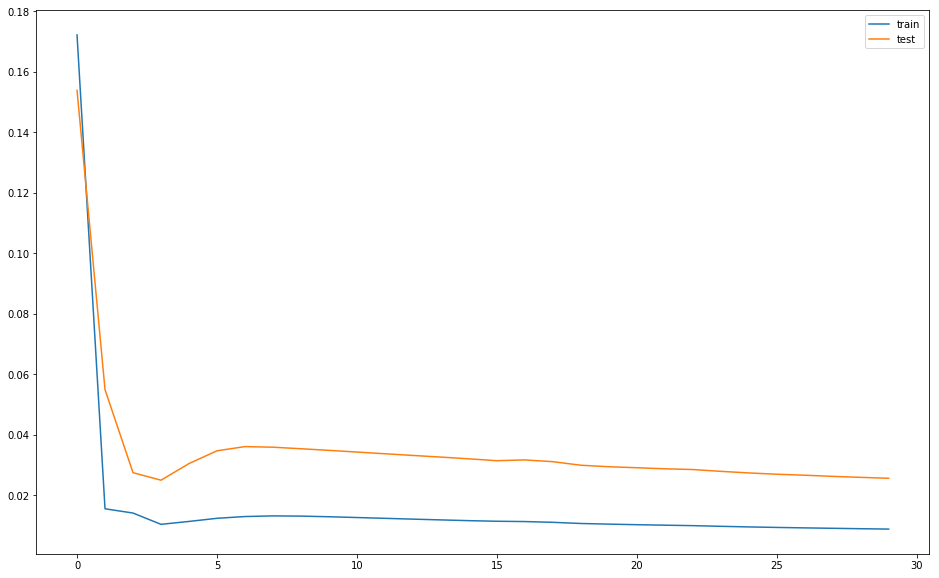

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

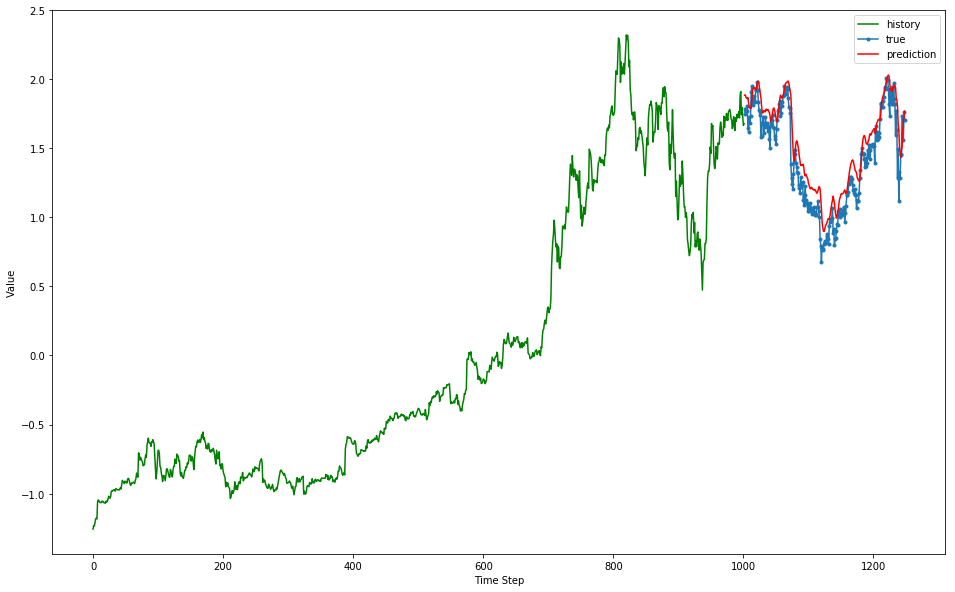

In [70]:
y_pred = model.predict(X_test)

plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

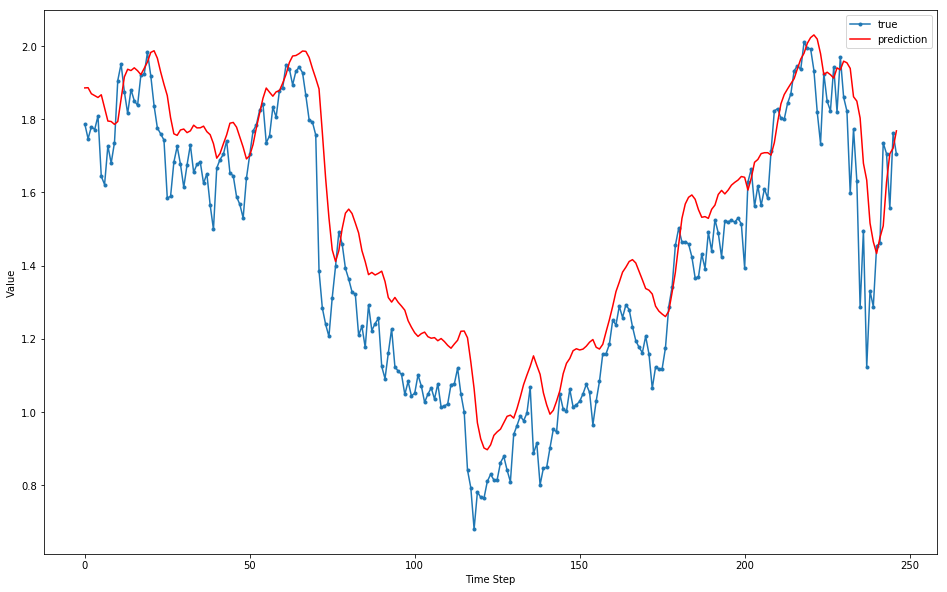

In [72]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();